In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size

INIT_LR = 1e-3
EPOCHS = 75
BS = 48

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

imagePaths = list(paths.list_images("dataset_new_test"))
data = []
labels = []


In [4]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)


In [5]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)


In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [7]:
# partition the data into training and testing splits using 60% of
# the data for training and the remaining 40% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.40, stratify=labels, random_state=42)


In [8]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [9]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


In [10]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [11]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [13]:
# train the head of the network

H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
6/6 [==============================] - 75s 13s/step - loss: 0.8005 - accuracy: 0.5560 - val_loss: 0.6070 - val_accuracy: 0.6068
Epoch 2/75
6/6 [==============================] - 83s 14s/step - loss: 0.6707 - accuracy: 0.5972 - val_loss: 0.5347 - val_accuracy: 0.8252
Epoch 3/75
6/6 [==============================] - 75s 12s/step - loss: 0.5872 - accuracy: 0.6834 - val_loss: 0.4711 - val_accuracy: 0.8495
Epoch 4/75
6/6 [==============================] - 76s 13s/step - loss: 0.4717 - accuracy: 0.7876 - val_loss: 0.4240 - val_accuracy: 0.8495
Epoch 5/75
6/6 [==============================] - 74s 12s/step - loss: 0.4029 - accuracy: 0.8378 - val_loss: 0.3705 - val_accuracy: 0.9320
Epoch 6/75
6/6 [==============================] - 77s 13s/step - loss: 0.3868 - accuracy: 0.8785 - val_loss: 0.3351 - val_accuracy: 0.9515
Epoch 7/75
6/6 [==============================] - 75s 12s/step - loss: 0.3409 - accuracy: 

Epoch 58/75
6/6 [==============================] - 79s 13s/step - loss: 0.0638 - accuracy: 0.9807 - val_loss: 0.0717 - val_accuracy: 0.9757
Epoch 59/75
6/6 [==============================] - 72s 12s/step - loss: 0.0548 - accuracy: 0.9807 - val_loss: 0.0720 - val_accuracy: 0.9757
Epoch 60/75
6/6 [==============================] - 73s 12s/step - loss: 0.0661 - accuracy: 0.9884 - val_loss: 0.0710 - val_accuracy: 0.9709
Epoch 61/75
6/6 [==============================] - 75s 13s/step - loss: 0.0504 - accuracy: 0.9846 - val_loss: 0.0729 - val_accuracy: 0.9660
Epoch 62/75
6/6 [==============================] - 77s 13s/step - loss: 0.0672 - accuracy: 0.9861 - val_loss: 0.0706 - val_accuracy: 0.9757
Epoch 63/75
6/6 [==============================] - 73s 12s/step - loss: 0.0526 - accuracy: 0.9807 - val_loss: 0.0705 - val_accuracy: 0.9757
Epoch 64/75
6/6 [==============================] - 74s 12s/step - loss: 0.0585 - accuracy: 0.9768 - val_loss: 0.0710 - val_accuracy: 0.9757
Epoch 65/75
6/6 [===

In [14]:
# make predictions on the testing set

predIdxs = model.predict(testX, batch_size=BS)


In [15]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [16]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.98      0.96      0.97        83
      normal       0.98      0.98      0.98       123

    accuracy                           0.98       206
   macro avg       0.98      0.97      0.97       206
weighted avg       0.98      0.98      0.98       206



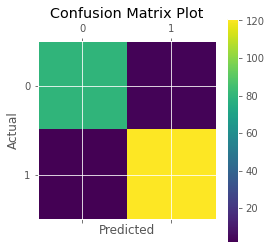

In [21]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

plt.matshow(cm)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();


In [18]:
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[[ 80   3]
 [  2 121]]
acc: 0.9757
sensitivity: 0.9639
specificity: 0.9837


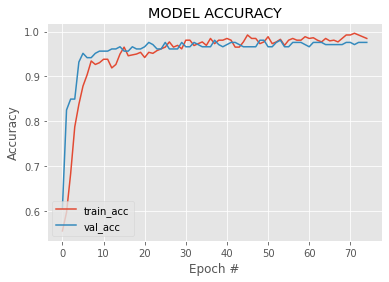

<function matplotlib.pyplot.show(close=None, block=None)>

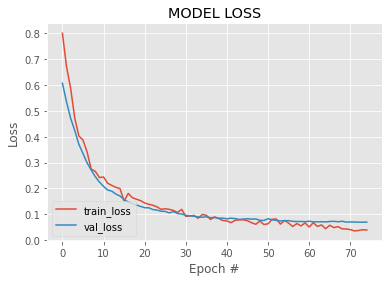

In [19]:
# plot the training loss and accuracy
N = EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("MODEL ACCURACY")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("MODEL LOSS")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show


In [23]:

history_dict = H.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
